<a href="https://colab.research.google.com/github/rahiakela/transfer-learning-for-natural-language-processing/blob/main/2-getting-started-with-baselines/4_ELMo_based_models_for_movie_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELMo based models for Movie Sentiment Classification

Our goal is to establish a set of baselines for a pair of concrete NLP problems, which we will later be able to use to measure progressive improvements gained from leveraging increasingly sophisticated transfer learning
approaches. In the process of doing this, we aim to advance your general NLP instincts and refresh your understanding of typical procedures involved in setting up problem-solving pipelines for such problems. You will review techniques ranging from tokenization to data structure and model selection. We first train some traditional machine learning models from scratch to establish some preliminary baselines for these problems.

We will focus on a pair of important representative example NLP problems – spam
classification of email, and sentiment classification of movie reviews. This exercise will arm you with a number of important skills, including some tips for obtaining, visualizing and preprocessing data. 

Three major model classes will be covered, namely linear models such as logistic regression, decision-tree-based models such as random forests, and neural-network-based models such as ELMo. These classes are additionally represented by support vector machines (SVMs) with linear kernels, gradient-boosting machines (GBMs) and BERT respectively. 

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/content-classification-supervised-models.png?raw=1' width='800'/>



## Setup

Ref: https://stackoverflow.com/questions/57742410/error-on-scope-variable-while-using-tensorflow-hub

In [ ]:
!pip install keras==2.2.4 # critical dependency
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"

In [15]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import email        # email package for processing email messages
import random
import re
import time
import os


import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Initialize tensorflow/keras session
sess = tf.Session()
K.set_session(sess)

In [17]:
%%shell

wget -q "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
tar xzf aclImdb_v1.tar.gz

rm -rf aclImdb_v1.tar.gz
rm -rf aclImdb/train/unsup

## Preprocessing Movie Sentiment Data

This notebook is concerned with classifying movie reviews from IMDB into
positive or negative sentiments expressed. This is a prototypical sentiment analysis example that has been used widely in the literature to study many algorithms.

We will use a popular labeled dataset of 25000 reviews for this, which was assembled by scraping the popular movie review website IMDB and mapping the number of stars corresponding to each review to either 0 or 1 – depending on whether it was less than or greater than 5 out of 10 stars respectively.It has been used widely in prior NLP literature, and this familiarity is part of the reason we choose it as an illustrative example for baselining.

The sequence of steps used to preprocess each IMDB movie review before analysis is very similar to the one presented for the email spam classification example.

The first major difference is that no email headers are attached to these reviews, so the header extraction step is not applicable. 

Additionally, since some stopwords – including “no” and “not” – may
change the sentiment of the message, the stopword removal step may need to be carried out with extra care, first making sure to drop such stopwords from the target list. We did experiment with dropping such words from the list, and saw little to no effect on the result. This is likely because other non-stopwords in the reviews are very predictive features, rendering this step irrelevant.

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/spam-email-preprocessing.png?raw=1' width='800'/>


### IMDB Movie Review Dataset preprocessing

Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters.

In [18]:
n_sample = 1000   # number of samples to generate in each class
maxtokens = 50    # the maximum number of tokens per document
maxtokenlen = 20  # the maximum length of each token

With these hyperparameters specified, we can now create a single DataFrame for the overarching training dataset. Let’s take the opportunity to also perform remaining preprocessing tasks, namely removing stop words, punctuations and tokenizing.

#### Tokenization

Let’s proceed by defining a function to tokenize text by splitting them into 
words.

In [19]:
def tokenize(row):
  if row is None or row is "":
    tokens = ""
  else:
    tokens = row.split(" ")[:maxtokens]
  return tokens

#### Remove punctuation and unnecessary characters

**In order to ensure that classification is done based on language content only, we have to remove punctuation marks and other non-word characters from the emails.** We do this by employing regular expressions with the Python regex library. We also normalize words by turning them into lower case.

In [20]:
def reg_expressions(row):
  tokens = []
  try:
    for token in row:
      token = token.lower()          # make all characters lower case
      token = re.sub(r"[\W\d]", "", token)
      token = token[:maxtokenlen]    # truncate all tokens to hyperparameter maxtokenlen
      tokens.append(token)
  except:
    token = ""
    tokens.append(token)
  return tokens

#### Stop-word removal

Stop-words are also removed. Stop-words are words that are very common in text but offer no useful information that can be used to classify the text. Words such as is, and, the, are are examples of stop-words. The NLTK library contains a list of 127 English stop-words and can be used to filter our tokenized strings.

In [21]:
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
# it may be beneficial to drop negation words from the removal list, as they can change the positive/negative meaning of a sentence
stop_words.remove("no")
stop_words.remove("nor")
stop_words.remove("not")

In [23]:
def stop_word_removal(row):
  token = [token for token in row if token not in stop_words]
  token = filter(None, token)

  return token

### Converting the Sentiment Text Into Numbers

Before using this function to train a model, we will need to adapt our preprocessed data a bit for this model architecture.

We use the below function to combine each such list into a single text string. This is the format in which the ELMo TensorFlow hub model expects the input, and we are glad to oblige.

> **NOTE**: The combined string in this case has stopwords removed – steps that are often not required in deep learning practice due to the uncanny ability of artificial neural networks to figure out what is important and isn’t,
i.e., feature engineering, automatically. In our case, since we are trying to compare the strengths and weaknesses of the different model types for this problem, applying the same kind of preprocessing for all algorithms makes sense and is arguably the right approach. We note however that ELMo was pretrained on a corpus containing stopwords, as was BERT.

Having fully vectorized the dataset, we must remember that it is not shuffled with respect to classes, i.e., it contains Nsamp = 1000 spam emails followed by an equal number of nonspam emails. Depending on how this dataset is split, in our case by picking the first 70% for training and the remainder for testing, this could lead to a training set composed of spam only, which would obviously lead to failure. In order to create a randomized ordering of class samples in the dataset, we will need to shuffle the data in unison with the header/list of labels.


In [24]:
# shuffle raw data first
def unison_shuffle_data(data, header):
  p = np.random.permutation(len(header))
  data = data[p]
  header = np.asarray(header)[p]

  return data, header

Let's load dataset into a Numpy array after tokenizing, removing stopwords and punctuations, and shuffling.

In [25]:
# load data in appropriate form
def load_data(path):
  data, sentiments = [], []
  for folder, sentiment in (("neg", 0), ("pos", 1)):
    folder = os.path.join(path, folder)
    for name in os.listdir(folder):
      with open(os.path.join(folder, name), "r") as reader:
        text = reader.read()
      text = tokenize(text)            # tokenizing
      text = stop_word_removal(text)   # removing stopwords and punctuations
      text = reg_expressions(text)
      data.append(text)
      sentiments.append(sentiment)     # Track corresponding sentiment labels

  # converting to Numpy array
  data_np = np.array(data)
  # shuffling
  data, sentiments = unison_shuffle_data(data_np, sentiments)

  return data, sentiments

In [26]:
train_path = os.path.join("aclImdb", "train")
test_path = os.path.join("aclImdb", "test")

raw_data, raw_header = load_data(train_path)
print(raw_data.shape)
print(len(raw_header))

(25000,)
25000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


Let's take n_sample*2 random entries of the loaded data for training:

In [27]:
# Subsample required number of samples
random_indices = np.random.choice(range(len(raw_header)), size=(n_sample * 2, ), replace=False)
data_train = raw_data[random_indices]
header = raw_header[random_indices]

print("DEBUG::data_train::")
print(data_train[:5])

DEBUG::data_train::
[list(['i', 'watched', 'movie', '', 'years', 'ago', 'company', 'best', 'female', 'friend', 'i', 'got', 'judgment', 'teeth', 'pulled', 'i', 'feel', 'goodbr', 'br', 'i', 'ended', 'liking', 'big', 'time', 'its', 'hard', 'watch', 'take', 'account', 'deals', 'friendship', 'unwanted'])
 list(['the', 'movie', 'fun', 'staring', 'sunsheriff', 'pataki', 'total', 'retard', 'loves', 'nothing', 'better', 'sit', 'fat', 'rear', 'making', 'smoke', 'ring', 'puffy', 'cigars', 'drinking', 'booze', 'doctor', 'acts', 'like', 'zombie', 'version', 'nicholas', 'cage'])
 list(['rebar', 'astronaut', 'goes', 'worlds', 'first', 'space', 'mission', 'saturn', 'course', 'horror', 'movie', 'things', 'turn', 'ugly', 'returns', 'earth', 'survivor', 'stricken', 'bizarre', 'condition', 'causes', 'slowly', 'melt', 'lose', 'mind', 'unless'])
 list(['a', 'quiet', 'sweet', 'beutifully', 'nostalgic', 'movie', 'confronted', 'old', 'friends', 'surroundings', 'youth', 'memories', 'problems', 'sorrows', 'prese

Before proceeding, we need to check the balance of the resulting data with regards to class. In general, we don’t want one of the labels to represent most of the dataset, unless that is the distribution expected in practice.

In [28]:
# Display sentiments and their frequencies in the dataset, to ensure it is roughly balanced between classes
unique_elements, counts_elements = np.unique(header, return_counts=True)
print("Sentiments and their frequencies:")
print(unique_elements)
print(counts_elements)

Sentiments and their frequencies:
[0 1]
[1029  971]


In [29]:
# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data, header):
  converted_data, labels = [], []
  for i in range(raw_data.shape[0]):
    # combine list of tokens representing each email into single string
    out = " ".join(raw_data[i])
    converted_data.append(out)
    labels.append(header[i])
  converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]

  return converted_data, np.array(labels)

As the very last step of preparing the sentiment dataset for training by our baseline classifiers, we split it into independent training and testing or validation sets. This will allow us to evaluate the performance of the classifier on a set of data that was not used for training, an important thing
to ensure in machine learning practice. We elect to use 70% of the data for training, and 30% for testing/validation afterwards.

In [31]:
data_train, header = unison_shuffle_data(data_train, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7 * data_train.shape[0])  # get 70% index value

# 70% of data for training
train_x, train_y = convert_data(data_train[:idx], header[:idx])

# remaining 30% for testing
test_x, test_y = convert_data(data_train[idx:], header[idx:])

print("train_x/train_y list details, to make sure they are of the right form:")
print(len(train_x))
print(train_x[:5])
print(len(train_y))
print(train_y[:5])

train_x/train_y list details, to make sure they are of the right form:
1400
[['where begin movie bad thisbr br do mention cast unlikeable heroes the overthetop acting the dreadful scriptbr br no you say anyone pays money see film poor needs head looking at i']
 ['truly one dire films ive ever sat through ive never actually taken time write one felt compelled witnessing affront filmmaking feel somewhat aggrieved wasting time piece turd honest']
 ['i firstly completely confidently disagree user calls spoof crispin glover serious film he personally introduced film screening i saw chicago he worked film years first']
 ['citizen x superbly told true story hunt one historys worst serial killers what makes story even compelling took place soviet union sbr br  mild spoilers br br  viktor burakov magnificently played']
 ['i really get people made film thought worth work put it even puzzling watched film without feeling cheated  minutes something valuable like cleaning couch reading leviticus br

Since 70% of 2000 is 1400, looks good! (for n_sample=1000)

## Neural Network Models

Neural networks are the most important class of machine learning algorithms for handling perceptual problems such as computer vision and NLP.

we will train two representative pretrained neural network language models
on the two illustrative example problems we have been baselining.

The two models we will consider here are:

- **ELMo** – Embeddings from Language Models, and
- **BERT** – Bidirectional Encoder Representations from Transformers.

ELMo includes elements of convolutional and recurrent (specifically LSTM) elements, while the appropriately named BERT is transformer-based.

The simplest form of transfer learning fine-tuning will be employed, where a single dense classification layer is trained on top of the corresponding pretrained embedding over our dataset of labels.


### Embeddings from Language Models (ELMo)

The Embeddings from Language Models (ELMo) model, named after the popular Sesame Street character, was among the first models to demonstrate the effectiveness of transferring pretrained language model knowledge to general NLP tasks. The model was trained to predict the next word in a sequence of words, which can be done in an unsupervised manner on very large corpuses, and showed that the weights obtained as a result could generalize to a variety
of other NLP tasks.

It will suffice to mention here that the model employs character-level convolutions to build up preliminary embeddings of each word token, followed by bidirectional LSTM layers which introduce context of surrounding words into
the final embeddings produced by the model.

The ELMo model is available through the Tensorflow Hub, which provides an
easy platform for sharing Tensorflow models. We will use Keras with Tensorflow backend to build our model. In order to make the tensorflow hub model usable by Keras, we will need to define a custom Keras layer that instantiates it in the right format.

Let's create a custom tf hub ELMO embedding layer.

In [32]:
class ElmoEmbeddingLayer(Layer):

  def __init__(self, **kwargs):
    # initialize output dimension of ELMo embedding
    self.dimensions = 1024
    self.trainable = True
    super(ElmoEmbeddingLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    """function for building ELMo embedding"""
    # Download pretrained ELMo model from Tensorflow Hub
    self.elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=self.trainable, name="{}_module".format(self.name)) 
    # extract trainable parameters, which are only a small subset of the total - this is a constraint of
    # the tf hub module as shared by the authors - see https://tfhub.dev/google/elmo/2
    # the trainable parameters are 4 scalar weights on the sum of the outputs of ELMo layers 
    self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))

  def call(self, x, mask=None):
    """specify function for calling embedding"""
    result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1), as_dict=True, signature="default")["default"]

    return result

  def compute_output_shape(self, input_shape):
    """specify output shape"""
    return (input_shape[0], self.dimensions)

We now use the custom TF hub ELMo embedding layer within a higher-level function to define the overall model. More specifically, we put a dense trainable layer of output dimension 256 on top of the ELMo embedding.

In [33]:
def build_model():
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  dense = layers.Dense(256, activation="relu")(embedding)      # new layer outputting 256-dimensional feature vectors
  prediction = layers.Dense(1, activation="sigmoid")(dense)

  # we could use sigmoid activation as well, but we choose softmax
  # to enable us use sparse_categorical_crossentropy and sparse_categorical_accuracy below
  model = Model(inputs=[input_text], outputs=prediction)
  # use sparse_categorical_crossentropy and sparse_categorical_accuracy do avoid having to one-hot encode the labels
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model.summary()

  return model

In [34]:
# Build and fit
model = build_model()
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=5, batch_size=32)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________



Train on 1400 samples, validate on 600 samples
Epoch 1/5



1400/1400 [==============================] - 444s 317ms/step - loss: 0.6211 - acc: 0.6507 - val_loss: 0.5776 - val_acc: 0.7017
Epoch 2/5
1400/1400 [==============================] - 429s 307ms/step - loss: 0.5424 - acc: 0.7400 - val_loss: 0.5987 - val_acc: 0.6833
Epoch 3/5
1400/1400 [==============================] - 437s 312ms/step - loss: 0.5078 - acc: 0.7414 - val_loss: 0.6896 - val_acc: 0.6233
Epoch 4/5
1400/1400 [==============================] - 442s 316ms/step - loss: 0.4983 - acc: 0.7593 - val_loss: 0.5484 - val_acc: 0.7167
Epoch 5/5
1400/1400 [==============================] - 435s 311ms/step - loss: 0.4496 - acc: 0.7921 - val_loss: 0.5592 - val_acc: 0.7067


In [35]:
# Save trained model
model.save("ELMoModel.h5")

First of all, notice that we have added an additional layer on top the pretrained ELMo embedding, producing 256-dimensional feature vectors. We have also added a classification layer of output dimension 1. The activation function ‘sigmoid’ transforms its input into the interval between 0 and 1.

Its output can be interpreted as the probability of the positive class, and when it exceeds some prespecified threshold (usually 0.5) the corresponding input to the network can be classified as the said positive class.

We note that most of the trainable parameters in this case (approximately 260 thousand of them) are coming from the layers we added on top of the custom ELMo model. In other words, this is our first instance of transfer learning – learning a pair of new layers on top of the pretrained model shared by ELMo’s creators.

In practice, one can increase the value of this parameter until the speed of convergence of a typical problem instance does not benefit from the increase, or whenever the GPU memory is no longer large enough for a single data batch to
fit on it during an iteration of the algorithm, whichever happens first. Additionally, when dealing with a multi-GPU scenario, some evidence that the optimal scaling-up schedule of the batch size is linear in the number of GPUs, has been presented.

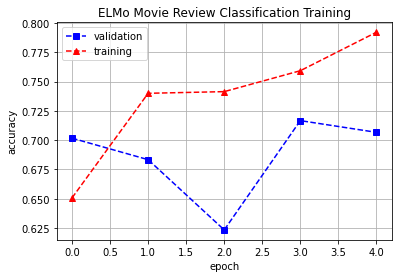

In [36]:
df_history = pd.DataFrame(history.history)

fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ELMo Movie Review Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()
# Save figures
fig.savefig('ELMoConvergence.eps', format='eps')
fig.savefig('ELMoConvergence.pdf', format='pdf')
fig.savefig('ELMoConvergence.png', format='png')
fig.savefig('ELMoConvergence.svg', format='svg')

We see that a validation accuracy of approximately 70.76% is attained at the 4th epoch, i.e., in under a minute. This performance is comparable to the performance of the logistic regression approach, which is only slightly better at 70.76%. We note that the behavior of the algorithm is stochastic, i.e., it behaves differently from run to run.

Finally, we note that the divergence of training and validation accuracies is suggestive of the beginning of overfitting as indicative in the figure. This
lends credence to the hypothesis that increasing the amount of signal by increasing the length of tokens, as specified by hyper-parameter maxtokenlen, and the number of tokens per email, as specified by maxtokens, may increase performance further. Naturally, increasing the number of samples per class by cranking up Nsamp should also work to improve performance.

Each epoch again takes approximately 10 seconds and a validation accuracy of approximately 70% is achieved in under a minute at the 3rd epoch.

**Note that some evidence of overfitting can be observed at the 3rd and later epochs, as the training accuracy continues to improve, i.e., the fit to the data improves, while the validation accuracy remains lower.**